In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score
sns.set()

In [4]:
logins=pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


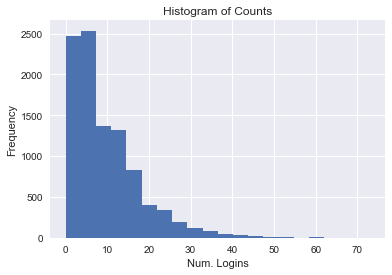

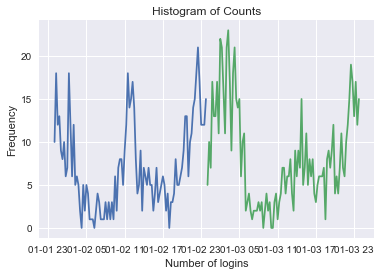

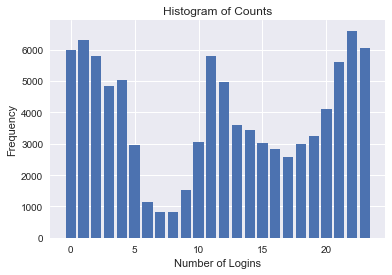

In [5]:
#aggregate based on 15 minute time intervals
#EDA by histogram plotting
counts=logins.resample('15min', on='login_time').count()
counts.columns=['counts']
plt.hist(counts['counts'],bins=20)
plt.xlabel('Num. Logins')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.show()
#EDA of Hist of two dates
plt.plot(counts['1/2/1970'])
plt.plot(counts['1/3/1970'])
plt.xlabel('Number of logins')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.show()
count_by_hour=counts.groupby(counts.index.hour).sum()#sums number of logins
plt.bar(count_by_hour.index,count_by_hour['counts'])#bargraph of counts/hr.
plt.xlabel('Number of Logins')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.show()

Summary: Login data was grouped into 15 minute intervals as per the instructions. It can be seen that the largest number of logins during the 15 minute time interval was at 60 minutes. Anohter pattern emerged in the day by day data which was there were two spikes of logins. The first was in the middle of the day around lunch and the second was 9pm till about 4 am.

Part 2: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

A key measure of success would be percentage of pickups before and after the experiment, since currently the drivers are staying in only one of the two cities. Percentages are easy to compare/compute and makes the effectiveness of the experiment easily measurable.

Outline of the experiment to compare effectiveness of proposed change:

1. Calculate the % of pickups in Gotham for each user
2. Calculate the % of pickups in Gotham for each user after the experiment
3. Graph change in % of pickups over time for each user/overall
4. Use a t-test to verify that the obersvations were not due to chance
5. If there was a statistically significant increase in the % of pickups we can say the experiment was successful. The exact increase that would be the most cost effective would be up to the business team.  One caveat would be that this experiment can't be designed on a holiday weekend which could cause spikes in either city. Another caveat would be that drivers might be centric to their own city.

In [10]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
data=pd.DataFrame(data)
data.head()
#We can't use pd.read here

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
data.index=data.index.rename('id')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
id,,,,,,,,,,,,
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [13]:
data_drop=data.dropna()
data_drop.info()
data_drop.head()
total=len(data.index)
data_retain=data[data.trips_in_first_30_days>0]#trips in first 30 days > 0
retain=len(data_retain.index)
retain_percentage=retain/total
print(retain_percentage)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null object
phone                     41445 non-null object
signup_date               41445 non-null object
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB
0.6922


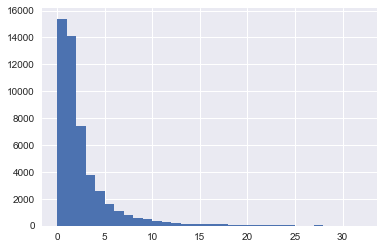

In [14]:
plt.hist(data.trips_in_first_30_days,bins=32,range=(0,32))
plt.show()

In [18]:
data_drop['retained']=data_drop['trips_in_first_30_days']>0
data_drop.head()

C:\Users\Shing Han\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
id,,,,,,,,,,,,,
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,True
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,True


In [25]:
y=data_drop['retained'].values
data_x=data_drop.drop(['trips_in_first_30_days','retained','last_trip_date','signup_date'],axis=1)
data_x=pd.get_dummies(data_x,drop_first=False)
X=data_x.values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)
logreg=LogisticRegression()
param_grid={'C':[.01,.1,1,10,100]}
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)
logreg_cv.fit(X_train, y_train)
predict=logreg_cv.predict(X_test)
score=logreg_cv.score(X_test,y_test)
print(score)

0.7233392311404214


In [27]:
accuracy=accuracy_score(y_test,predict)
precision=precision_score(y_test, predict)
recall=recall_score(y_test,predict)
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)

Accuracy: 0.7233392311404214
Precision: 0.7236099919419823
Recall: 0.9988876529477196


In [29]:
logreg.fit(X_train,y_train)
coef=logreg.coef_
columns=data_x.columns

data_coef=pd.DataFrame(data=coef[0],index=columns)
data_ranked=data_coef.sort_values(0)
data_ranked

,0
avg_rating_of_driver,-0.080513
avg_rating_by_driver,-0.030037
avg_dist,-0.025590
weekday_pct,-0.000148
surge_pct,-0.000095
avg_surge,0.107849
city_King's Landing,0.108850
ultimate_black_user,0.168038
city_Astapor,0.204396
phone_Android,0.372444


The above table displays the accuracy, precision, and recall of the model.  The recall is at ~.998 and the accuracy and precsion at ~.723. All three of  these indicators perform very well. We also see the feature importances above and observe the most important feature is being in Winterfell.

From the analysis we can make some insights and ask some questions.
1. Figure out why winterfell has a higher retention rate. Possible causes can be (layout of city, number of cars, types of drivers etc.) We can then determine if the causes are replicable in other cities.
2. Using Ultimate Black, increases retention rate so increasing ridership on Ultimate Black rides would help business.
3. Iphones have a slightly better retention rate than Android, so figuring out why that is (errors, bugs, ownership) would be another way to improve business.